In [ ]:
# Importar librerias
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import copysign, log10
import tensorflow as tf
from tensorflow.keras.models import load_model
from skimage.transform import resize
from sklearn.metrics.pairwise import polynomial_kernel
from keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm
import seaborn
import random
import shutil
import glob
from PIL import Image
from imutils import paths

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Rescaling
from tensorflow.keras.layers import Dropout, Convolution2D, MaxPooling2D, AveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img, DirectoryIterator
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [ ]:
# Configurar el tamaño de los plots
seaborn.set(rc={'figure.figsize':(15,10)})

cargamos el DRIVE, que es de donde tenemos nuestras imagenes.

In [ ]:
from google.colab import drive
# Montar el Drive
drive.mount('/content/gdrive/')
#call drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


# Obtener y preprocesar los datos

Definimos a donde queremos guardar nuestras imagenes

In [ ]:
# Esta ruta se debe cambiar a la ruta donde se desee que se guarde el dataset en drive
os.chdir('Path a donde guardar datos')

Importamos las imagenes de nuestro dataset.
Consideremos la clase 0 de nuestra carpeta

In [ ]:
# Ruta base de las carpetas de las clases
ruta_base = 'Path a dataset of DDH x-ray images'

# Mapeo de nombres de clase a identificadores únicos
mapeo_clases = {'DDH': 0, 'Normal': 1}  # Puedes agregar más clases aquí y asignar identificadores únicos

# Lista para almacenar las imágenes y etiquetas
imagenes = []
labels = []

# Iterar sobre las carpetas de las clases
for clase in os.listdir(ruta_base):
    carpeta_clase = os.path.join(ruta_base, clase)

    # Verificar si es una carpeta
    if os.path.isdir(carpeta_clase):
        # Obtén el identificador único para la clase actual
        etiqueta = mapeo_clases.get(clase, -1)  # Usamos -1 si la clase no está en el mapeo

        # Iterar sobre los archivos en la carpeta de la clase
        for nombre_imagen in os.listdir(carpeta_clase):
            ruta_imagen = os.path.join(carpeta_clase, nombre_imagen)
            imagen = cv2.imread(ruta_imagen)  # Cambia esta función según tus necesidades

            # Asociar la etiqueta correspondiente
            if etiqueta != -1:
                imagenes.append(imagen)
                labels.append(etiqueta)

# Convierte las listas a arreglos de NumPy
imagenes = np.array(imagenes)
labels = np.array(labels)


In [ ]:
# Funcion para normalizar la intensidad de las imagenes entre -1 y 1
def normalizar_imgs(imagenes):
  # Convertir a flotante
  imagenes = imagenes.astype("float32")
  # Normalizar
  imagenes = (imagenes - 127.5) / 127.5
  return imagenes

# Funcion para escalar las imagenes
def escalar_imgs(imagenes, nueva_forma):
  lista_imgs = []
  for imagen in imagenes:
    img_escalada = resize(imagen, nueva_forma, 0)
    lista_imgs.append(img_escalada)
  return np.asarray(lista_imgs)

In [ ]:
# Separar las imagenes por clase
# Aqui se pueden cargar todas las imagenes o para ahorrar espacio en memoria, se puede hacer una funcion
# para cargar solo un tipo de mamografias
imagenes0 = imagenes[labels == 0]
imagenes1 = imagenes[labels == 1]

In [ ]:
del imagenes
del labels

In [ ]:
# Funcion para obtener n imagenes reales del dataset
def obtener_imgs_reales(dataset, n):
  idx = np.random.randint(0, len(dataset), n)
  X = dataset[idx]
  # Asignar la etiqueta de real (1)
  y = np.ones((n, 1))
  return X, y

# Funcion para generar n vectores de ruido muestreando de una distribucion normal, esta es la entrada del generador
# El vector de ruido tiene dimension de 128
def generar_ruido(n):
  X = np.random.randn(100 * n)
  X = X.reshape(n, 100)
  return X

# Funcion para obtener n imagenes falsas del generador
def obtener_imgs_fake(generador, n):
  input = generar_ruido(n)
  X = generador.predict(input)
  # Asignar la etiqueta de falso (0)
  y = np.zeros((n, 1))
  return X, y

In [ ]:
# Cargar las GAN para cada tipo de mamografiafa
GAN0 = load_model('Modelo generado GAN 0.h5', compile=False)
GAN1 = load_model('Modelo generado GAN 1.h5', compile=False)

# Calcular momentos de Hu y graficar histogramas

In [ ]:
# Funcion para calcular los momentos de hu de un grupo de imagenes
def calcular_momentos_hu(imagenes):
  # Matriz para guardar los 7 momentos de Hu de cada imagen
  momentos_hu = []
  for i in range(len(imagenes)):
    # Calcular los momentos de la imagen
    moments = cv2.moments(imagenes[i, :, :, 0])  # Usar solo el primer canal de la imagen
    # Calcular los momentos de Hu a partir de los momentos de la imagen
    huMoments = cv2.HuMoments(moments)
    # Iterar sobre cada momento
    for i in range(7):
      # Aplicar una transformacion logaritmica a cada momento para que tengan una escala parecida y poder comparar los momentos
      huMoments[i] = -1* copysign(1.0, huMoments[i]) * log10(abs(huMoments[i]))
    momentos_hu.append(huMoments[:,0])
  return np.array(momentos_hu)

In [ ]:
# Funcion para graficar histogramas de los momentos de hu
def graficar_hist(reales, fake):
  # Se le pasa a la funcion los dataframes con los momentos de las imagenes reales y los de las generadas
  # Graficar un histograma para cada momento de Hu
  plt.figure(figsize=(20, 10))
  for i in range(7):
    plt.subplot(2, 4, i+1)
    plt.title("Momento " + str(i), fontsize=14)
    plt.xlabel("Valores", fontsize=14)
    plt.ylabel("Frecuencia", fontsize=12)
    reales[i].hist(color="skyblue", bins=50)
    fake[i].hist(alpha=0.6, color="red", bins=50)
  plt.show()

4/4 [==============================] - 13s 3s/step
Histogramas para imagenes del tipo 0


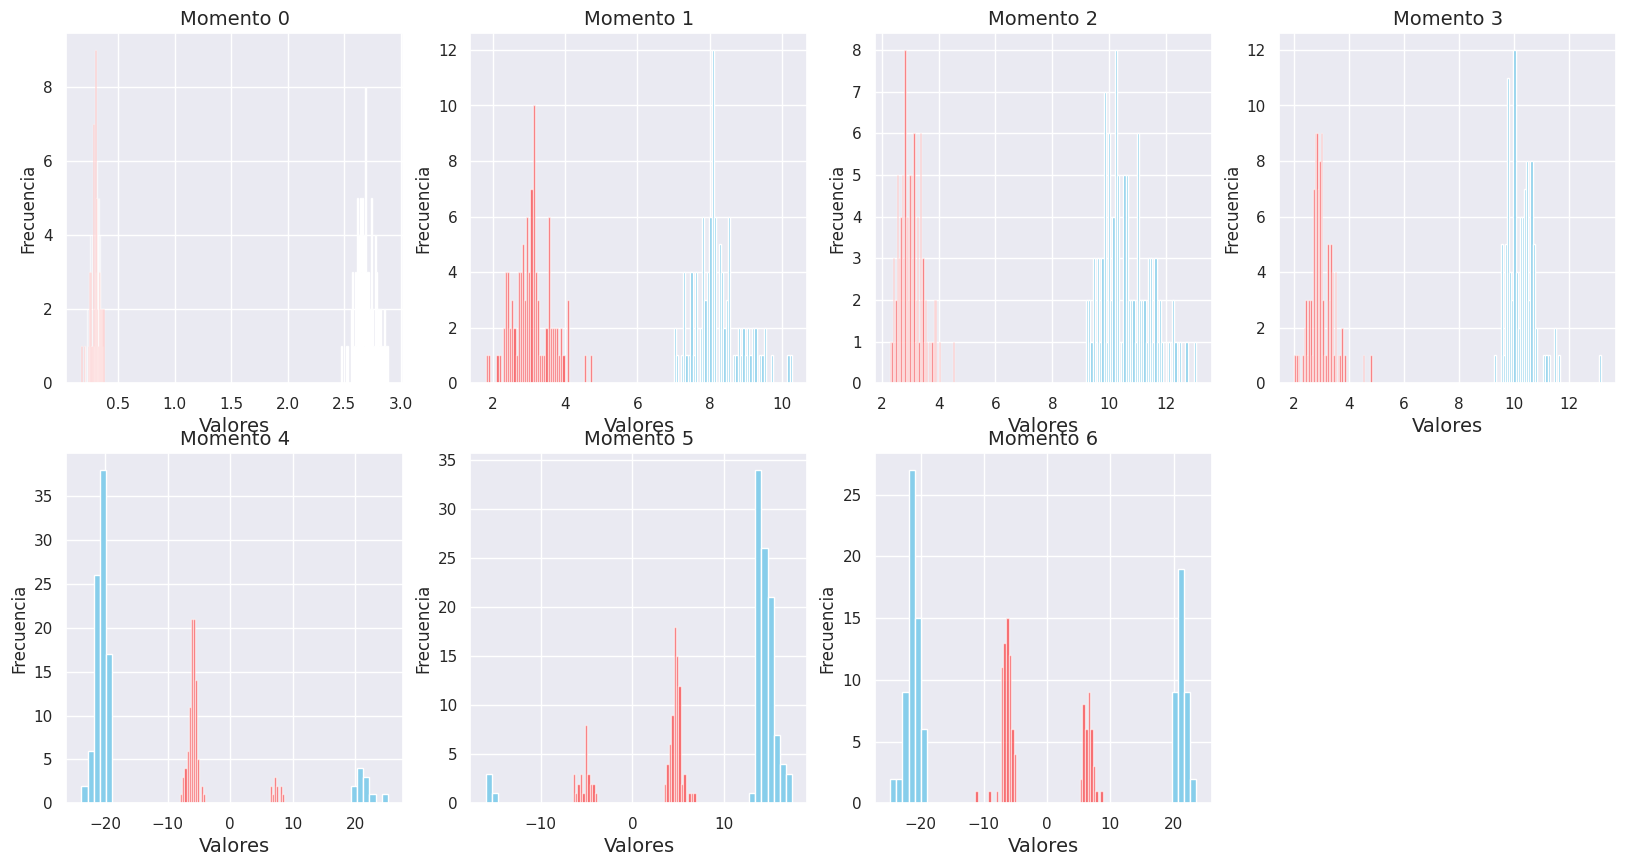

4/4 [==============================] - 13s 3s/step
Histogramas para imagenes del tipo 1


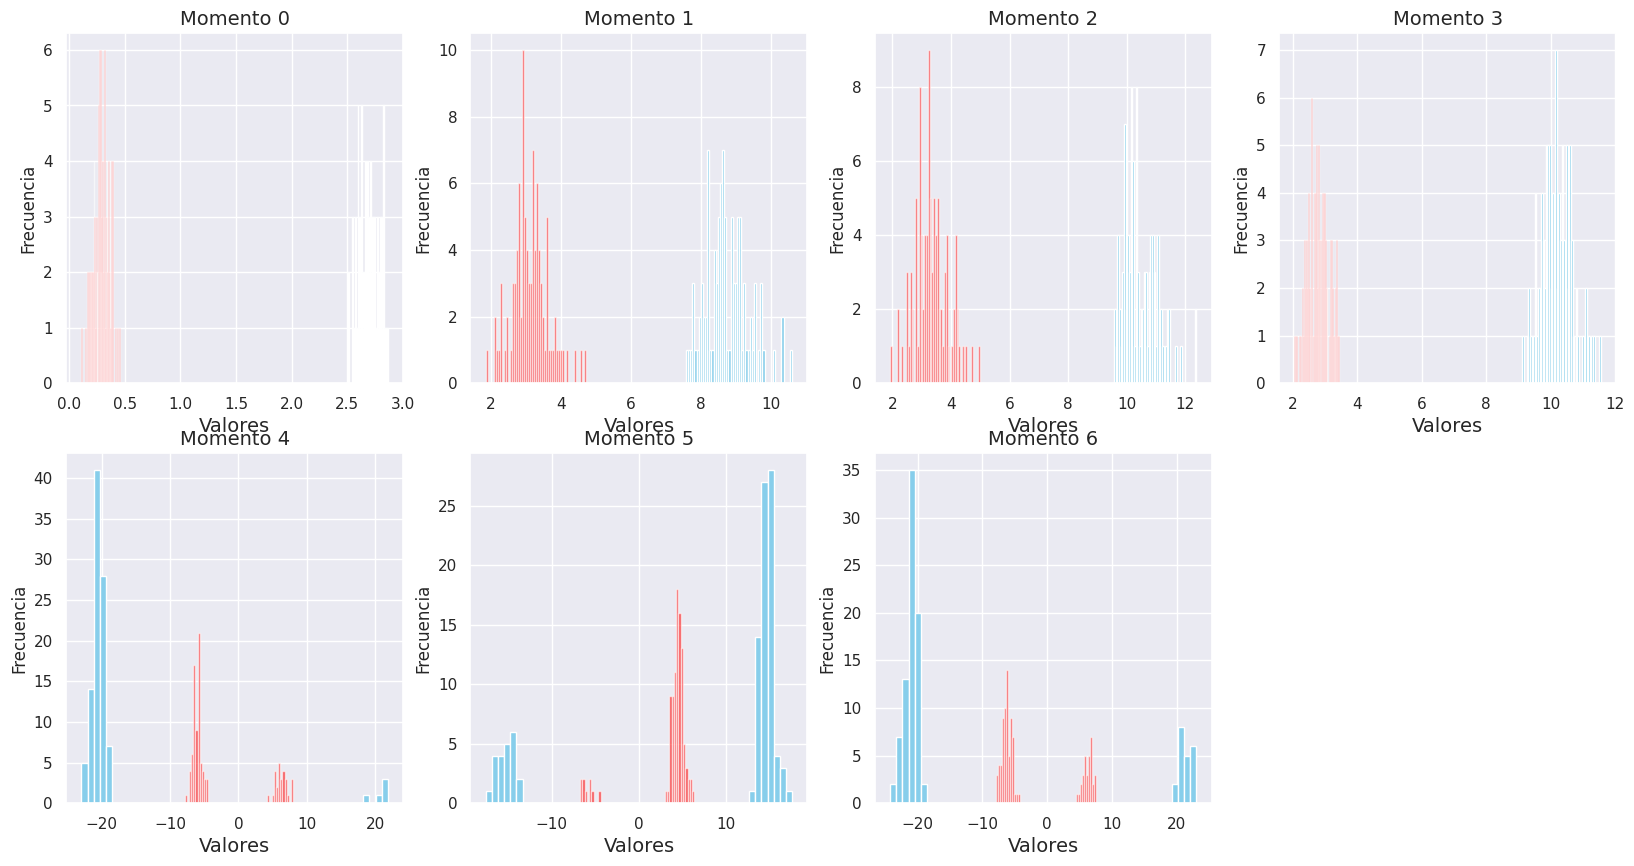

In [ ]:
# Graficar los histogramas para cada tipo de mamografia
for i in range(2):
  # Generar imagenes
  imgs_fake, _ = obtener_imgs_fake(globals()["GAN"+str(i)], 100)
  # Intensidades en el rango [0,1]
  imgs_fake = (imgs_fake + 1)/2

  # Cargar imagenes reales del tipo i
  imgs_real = escalar_imgs(globals()["imagenes"+str(i)][:100], (256, 256, 3))

  # Calcular momentos de Hu
  momentos_hu_fake = calcular_momentos_hu(imgs_fake)
  momentos_hu_reales = calcular_momentos_hu(imgs_real)

  # Convertir primero los momentos de Hu a DataFrame para poder graficar el histograma con pandas
  reales = pd.DataFrame(momentos_hu_reales)
  fake = pd.DataFrame(momentos_hu_fake)
  # Graficar histogramas
  print(f"Histogramas para imagenes del tipo {i}")
  graficar_hist(reales, fake)

# Creación del datset con imagenes sinteticas y originales

**CLASE: DDH**

Creamos la carpeta

In [ ]:
import os

# Rutas de las carpetas que contienen las imágenes
ruta_carpeta1 = ''  # Ruta de la primera carpeta
ruta_carpeta2 = ''  # Ruta de la segunda carpeta

# Nombre de la nueva carpeta en Google Drive
nombre_nueva_carpeta = 'DDH_GAN'

# Ruta de la nueva carpeta que se creará en Google Drive
ruta_nueva_carpeta = os.path.join('Dataset_Aumentado_GAN_256', nombre_nueva_carpeta)

# Crea la nueva carpeta en Google Drive
os.makedirs(ruta_nueva_carpeta, exist_ok=True)

copiamos las imagenes

In [ ]:
import shutil

# Copia las imágenes de la primera carpeta a la nueva carpeta
for archivo in os.listdir(ruta_carpeta1):
    ruta_origen = os.path.join(ruta_carpeta1, archivo)
    ruta_destino = os.path.join(ruta_nueva_carpeta, archivo)
    shutil.copy(ruta_origen, ruta_destino)

# Copia las imágenes de la segunda carpeta a la nueva carpeta
for archivo in os.listdir(ruta_carpeta2):
    ruta_origen = os.path.join(ruta_carpeta2, archivo)
    ruta_destino = os.path.join(ruta_nueva_carpeta, archivo)
    shutil.copy(ruta_origen, ruta_destino)


**CLASE: Normal**

Creamos la carpeta

In [ ]:
import os

# Rutas de las carpetas que contienen las imágenes
ruta_carpeta1 = ''  # Ruta de la primera carpeta
ruta_carpeta2 = ''  # Ruta de la segunda carpeta

# Nombre de la nueva carpeta en Google Drive
nombre_nueva_carpeta = 'Normal_GAN'

# Ruta de la nueva carpeta que se creará en Google Drive
ruta_nueva_carpeta = os.path.join('', nombre_nueva_carpeta)

# Crea la nueva carpeta en Google Drive
os.makedirs(ruta_nueva_carpeta, exist_ok=True)

copiamos las imagenes

In [ ]:
import shutil

# Copia las imágenes de la primera carpeta a la nueva carpeta
for archivo in os.listdir(ruta_carpeta1):
    ruta_origen = os.path.join(ruta_carpeta1, archivo)
    ruta_destino = os.path.join(ruta_nueva_carpeta, archivo)
    shutil.copy(ruta_origen, ruta_destino)

# Copia las imágenes de la segunda carpeta a la nueva carpeta
for archivo in os.listdir(ruta_carpeta2):
    ruta_origen = os.path.join(ruta_carpeta2, archivo)
    ruta_destino = os.path.join(ruta_nueva_carpeta, archivo)
    shutil.copy(ruta_origen, ruta_destino)
